# Adversarial attacks project Benjamin

In [59]:
from attacks import compute_grad_finite_diff, compute_gradient, batch_pgd_attack
from test_project import test_PGD_attacked_accuracy
from settings import PGD_NB_ITERS, PGD_STEPSIZE, PGD_EPS
from CIFARLoader import CIFAR_Loader
from model import Net
import torch.nn as nn
import numpy as np
import torch
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# for PGD, optimal tau:
eps = 1e-2
n_it = 40
eps*255/4


0.6375000000000001

In [29]:
device = "mps"
net = Net()
net.load("./models/default_model.pth")
_=net.to(device)

In [39]:
data_loader = CIFAR_Loader(batch_size=32,train_eval_frac=0.9,root_folder="data")
test_loader = data_loader.get_test_loader()
train_loader, validation_loader = data_loader.get_train_eval_loaders()
train_dataset, validation_dataset = data_loader.get_train_eval_datasets()

im, lab = next(iter(validation_loader))
print(im.shape)
im, lab = next(iter(test_loader))
print(im.shape)
im, lab = next(iter(train_loader))
print(im.shape)


Files already downloaded and verified
Files already downloaded and verified
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])


In [52]:
print(len(train_loader),len(test_loader),len(validation_loader))

1407 313 157


In [34]:
test_PGD_attacked_accuracy(net, test_loader=validation_loader,
                                                device=device,iters=40,eps=1e-3,step_size=2/255,num_samples=1)

Testing PGD mode: 100%|██████████| 157/157 [00:35<00:00,  4.47it/s]


70.82

In [15]:
im.shape

torch.Size([3, 32, 32])

In [50]:
for x, e in test_loader:
    break
x.shape

torch.Size([32, 3, 32, 32])

In [51]:
acc_pgd = test_PGD_attacked_accuracy(net, test_loader=test_loader,
                                                device=device,iters=PGD_NB_ITERS,eps=PGD_EPS,
                                                step_size=PGD_STEPSIZE,num_samples=1)

100%|██████████| 313/313 [00:53<00:00,  5.85it/s]


## Testing finite difference method vs FGSM

In [4]:
images_labels = next(iter(test_loader))
images, labels = images_labels
first_image = images[0].to(device).reshape(1,3,32,32)
first_label = labels[0].to(device).reshape(1)

loss_function = nn.NLLLoss()

In [94]:
gradient = compute_gradient(net, loss_function=loss_function,
    input_images = first_image,target = first_label )

norms=[]
for k in range(1,15):
    eps = 10**(-k)
    finite_grad =  compute_grad_finite_diff(net, single_image = first_image, label= first_label, loss=loss_function,
                            device = device,finite_epsilon=eps)
    norm = torch.norm(gradient-finite_grad).item()
    print(f"Norm for {eps}: {norm}")
    norms.append(norm)

Norm for 0.1: 0.12181761115789413
Norm for 0.01: 0.023822780698537827
Norm for 0.001: 0.006962349638342857
Norm for 0.0001: 0.0668950006365776
Norm for 1e-05: 0.6812933683395386
Norm for 1e-06: 5.581231594085693
Norm for 1e-07: 36.95890808105469
Norm for 1e-08: 76.81218719482422
Norm for 1e-09: 0.8057678937911987
Norm for 1e-10: 0.8057678937911987
Norm for 1e-11: 0.8057678937911987
Norm for 1e-12: 0.8057678937911987
Norm for 1e-13: 0.8057678937911987
Norm for 1e-14: 0.8057678937911987


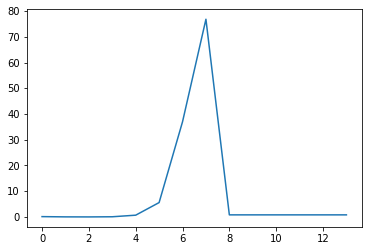

In [95]:
plt.plot(norms)

In [82]:
eps = 1e-5
finite_grad =  compute_grad_finite_diff(net, single_image = first_image, label= first_label, loss=loss_function,
                        device = device,finite_epsilon=eps)
print(f"Norm for {eps}: {torch.norm(gradient-finite_grad).item()}")

Norm for 1e-05: 0.6812933683395386


In [89]:
e = gradient.max().item()-gradient.min().item()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


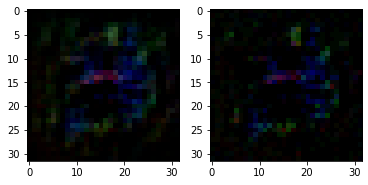

In [90]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,2)
ax = ax.ravel()
ax[0].imshow(gradient.detach().cpu().reshape(3,32,32).permute(1,2,0).numpy()/e)
ax[1].imshow(finite_grad.detach().cpu().reshape(3,32,32).permute(1,2,0).numpy()/e)


In [84]:
print(gradient.max().item(),gradient.min().item())
print(finite_grad.max().item(),finite_grad.min().item())

0.06721653044223785 -0.10195200890302658
0.06556511670351028 -0.1251697689294815


PLotting the evolution of the accuracies while training with robustness to PGD

In [71]:
comb_train_loss = [
    1.2340,
1.6815,
1.3529,
1.5825,
0.8666,
0.7937,
1.0152,
1.1246,
1.1110,
0.3785,
1.5416,
0.9500,
1.0007,
0.8872,
0.5661,
0.8527,
0.7232,
0.4909,
1.0321,
0.5132
]

com_eval_loss=[
    1.5622,
    1.4612,
    1.3385,
    1.3738,
    1.2667,
    1.2212,
    1.2161,
    1.1961,
    1.1807,
    1.1574,
    1.1509,
    1.1312,
    1.1579,
    1.1225,
    1.1460,
    1.1316,
    1.1004,
    1.0972,
    1.1114,
1.1295
]

eval_accuracy = [
43.1,47.0,51.7,51.0,54.1,56.7,56.8,57.1,57.8,59.4,59.8,60.2,59.2,60.7,59.8,60.4,61.2,61.0,61.0,61.4

]

pgd_accuracy = [
   39.7,42.94,45.08,44.04,45.7,47.52,47.28,48.66,48.28,48.46,47.62,47.96,48.06,48.14,46.56,48.76,49.3,49.58,49.32,47.96
   ]

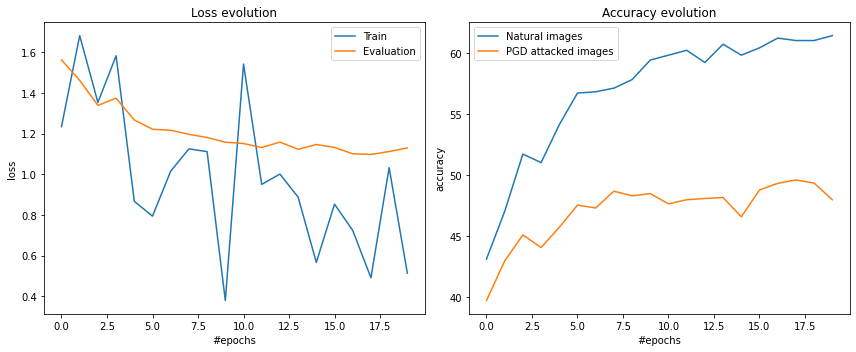

In [85]:
x = range(len(com_eval_loss))
fig, axs = plt.subplots(1,2,layout = 'tight',figsize=(12, 5))
axs[0].plot(x,comb_train_loss, label = 'Train')
axs[0].plot(x,com_eval_loss, label = 'Evaluation')
axs[1].plot(x,eval_accuracy, label = 'Natural images')
axs[1].plot(x,pgd_accuracy, label = 'PGD attacked images')
axs[0].set_xlabel("#epochs")
axs[0].set_ylabel("loss")
axs[1].set_xlabel("#epochs")
axs[1].set_ylabel("accuracy")
axs[0].legend()
axs[0].set_title("Loss evolution")
axs[1].set_title("Accuracy evolution")
axs[1].legend()
plt.savefig("Robust to PGD train.png")